<a href="https://colab.research.google.com/github/subharaj3/Plant-Disease-Prediction-Model/blob/main/Plant_Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'new-plant-diseases-dataset' dataset.
Path to dataset files: /kaggle/input/new-plant-diseases-dataset


Importing Libraries

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader as dl
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Enabling device

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device {device}")

Using device cuda


Loading Data

In [ ]:
path = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"

train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train = datasets.ImageFolder(path + "/train",transform = train_transform)
test = datasets.ImageFolder(path + "/valid",transform = test_transform)

train = dl(train, batch_size=64, shuffle = True, num_workers=2, pin_memory=True)
test = dl(test, batch_size=64, shuffle = False, num_workers=2, pin_memory=True)

Model Architecture

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv = nn.Sequential(

            ## CNN Layer 1
            nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            ## CNN Layer 2
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            ## CNN Layer 3
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            ## CNN Layer 4
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            ## CNN Layer 1
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256,38)
        )

    def forward(self,x):
        x = self.conv(x)
        x = self.global_pool(x)
        x = self.fc1(x)
        return x

Creating Model

In [ ]:
model = CNN()
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

In [ ]:
epochs = 15
y_true = []
y_pred = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0

    for features, labels in train:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()

        pred = model(features)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(pred, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()

    train_acc=(correct/total)*100
    avg_train_loss = running_loss / len(train)

    print(f"Epoch: {epoch + 1}/15 | Loss : {avg_train_loss:.4f} | Training Accuracy : {train_acc:.2f}")

Epoch: 1/15 | Loss : 1.3237 | Training Accuracy : 61.86
Epoch: 2/15 | Loss : 0.5703 | Training Accuracy : 82.53
Epoch: 3/15 | Loss : 0.3685 | Training Accuracy : 88.51
Epoch: 4/15 | Loss : 0.2838 | Training Accuracy : 91.05
Epoch: 5/15 | Loss : 0.2324 | Training Accuracy : 92.64
Epoch: 6/15 | Loss : 0.1945 | Training Accuracy : 93.89
Epoch: 7/15 | Loss : 0.1703 | Training Accuracy : 94.63
Epoch: 8/15 | Loss : 0.1479 | Training Accuracy : 95.33
Epoch: 9/15 | Loss : 0.1339 | Training Accuracy : 95.75
Epoch: 10/15 | Loss : 0.1214 | Training Accuracy : 96.17
Epoch: 11/15 | Loss : 0.1138 | Training Accuracy : 96.38
Epoch: 12/15 | Loss : 0.1057 | Training Accuracy : 96.57
Epoch: 13/15 | Loss : 0.0988 | Training Accuracy : 96.82
Epoch: 14/15 | Loss : 0.0956 | Training Accuracy : 96.91
Epoch: 15/15 | Loss : 0.0848 | Training Accuracy : 97.28


Metrics

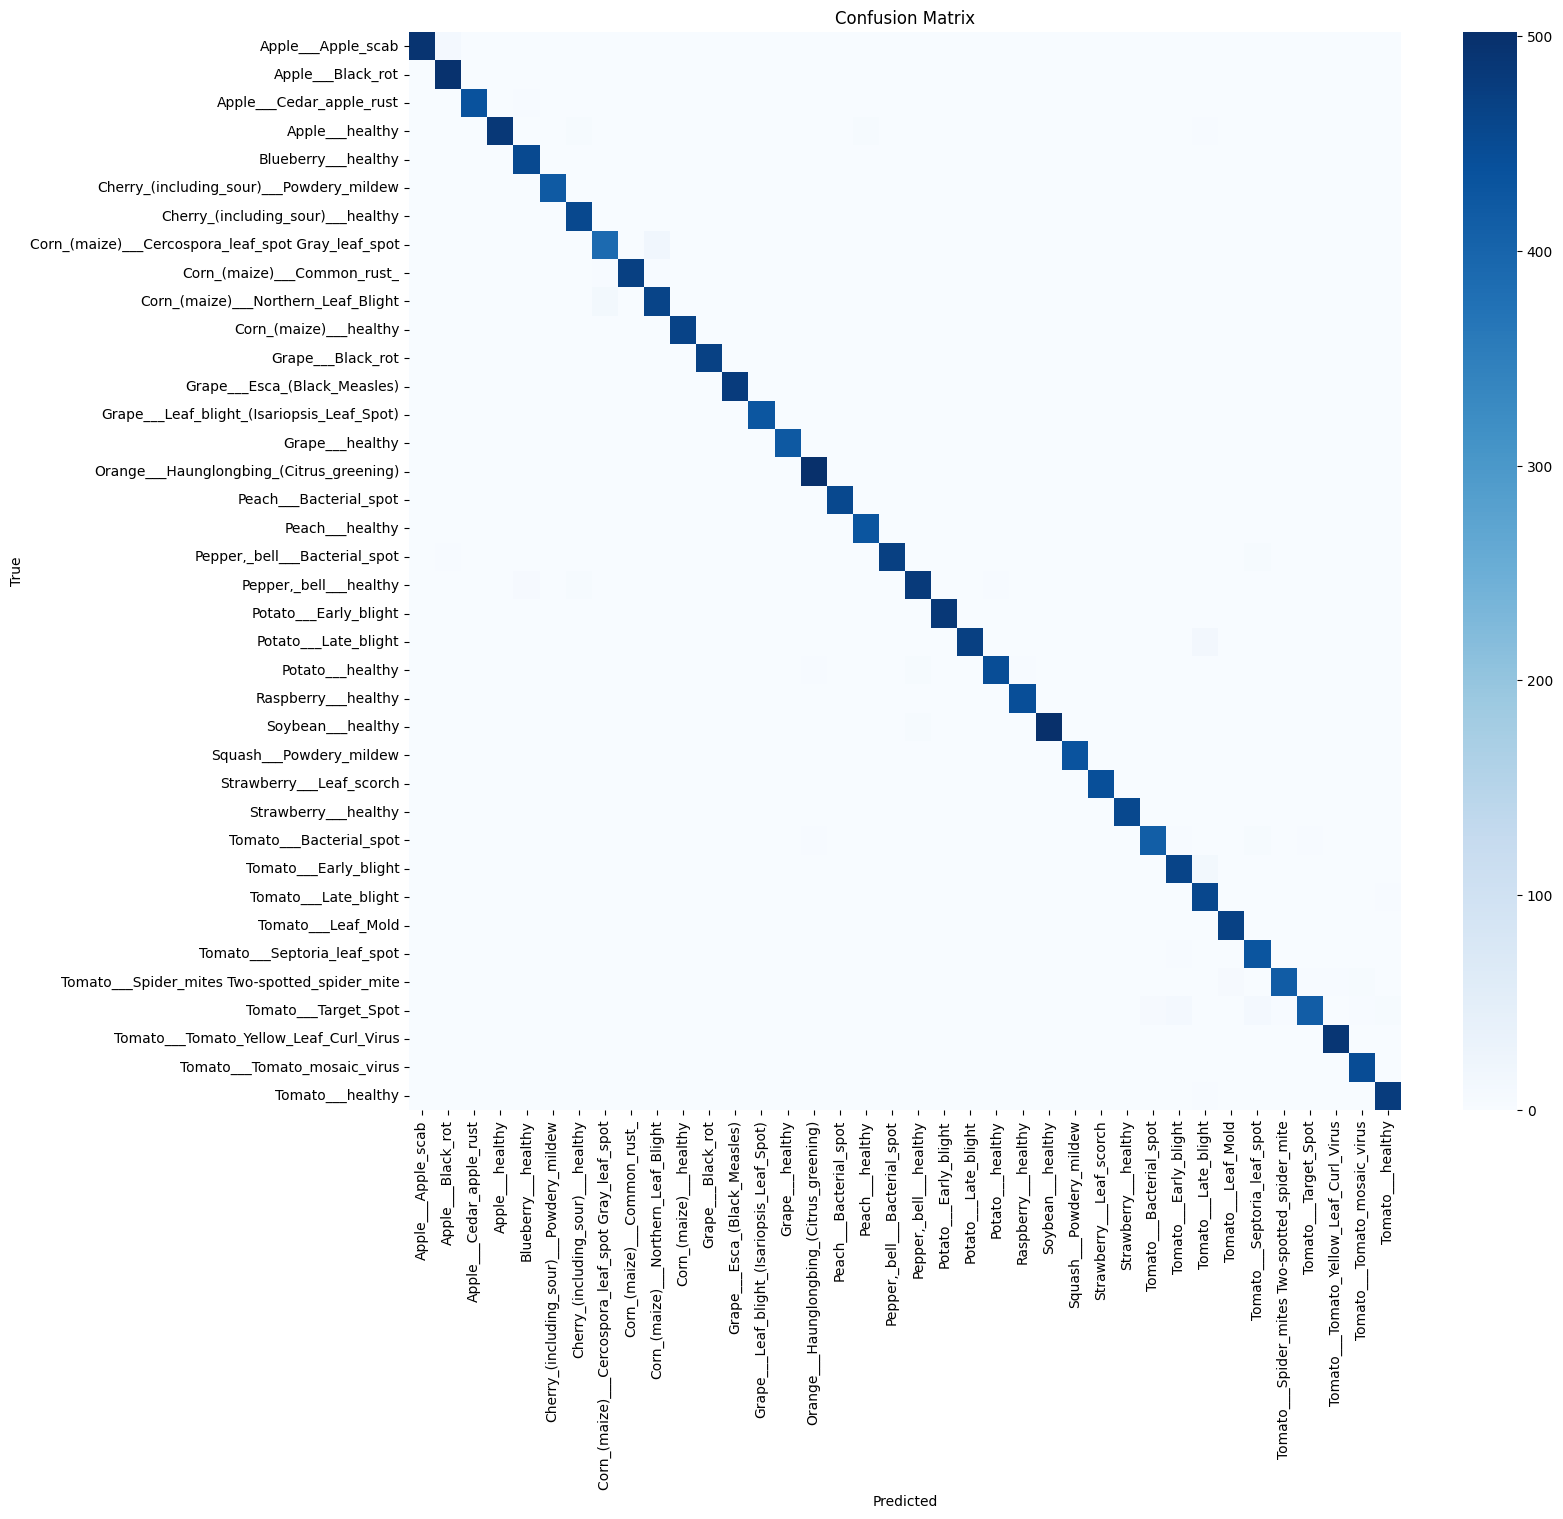

Test accuracy: 98.66264511723196


In [ ]:
model.eval()

val_correct = 0
val_total = 0

y_true = []
y_pred = []

with torch.no_grad():
  for features, labels in test:
      features, labels = features.to(device), labels.to(device)
      preds = model(features)
      _, predicted = torch.max(preds, 1)

      val_total += labels.size(0)
      val_correct += (predicted == labels).sum().item()

      y_true.extend(labels.cpu().numpy())
      y_pred.extend(predicted.cpu().numpy())

val_acc = (val_correct / val_total) * 100

cm = confusion_matrix(y_true, y_pred)
class_names = test.dataset.classes

plt.figure(figsize=(16,14))
sns.heatmap(
    cm,
    xticklabels=class_names,
    yticklabels=class_names,
    annot=False,
    cmap="Blues"
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(f"Test accuracy: {val_acc}")

In [ ]:
torch.save(model.state_dict(), "plant_disease.pth")